## Explaining Sentence Matchings

In this example, we will see how to use the `OTMatchingExplainer` to explain a transport (matching) plan. Such a matching $\Pi_{ij} \geq 0$ satisfies the additional constraints:

$$
\sum_{1 \leq j \leq n} \Pi_{ij} = a_i, \sum_{1 \leq i \leq m} \Pi_{ij} = b_j, 
$$

where $\sum_{1 \leq i \leq m} a_i = \sum_{1 \leq j \leq n} b_j = 1$. A matching that satisfies the above is termed an **optimal transport** plan.

Note: to explain a matching $\Pi_{ij} \geq 0$ that does not satisfy the optimal transport contrains, one may use the *sinkhorn-knopp* projection as described in the following reference, to project to a closest matching that does.

M. Cuturi, Sinkhorn Distances : Lightspeed Computation of Optimal Transport, Advances in Neural Information Processing Systems (NIPS) 26, 2013

### Preparation

This demo uses:
1. sentence pairs from the e-SNLI dataset, see reference below.
2. embeddings from GLoVe 
3. POT: Python optimal transport package 

Camburu, Oana-Maria, Tim Rocktäschel, Thomas Lukasiewicz, and Phil Blunsom. 2018. “E-SNLI: Natural Language Inference with Natural Language Explanations.” ArXiv:1812.01193 [Cs], December. 

Pennington, Jeffrey, Richard Socher, and Christopher Manning. 2014. “Glove: Global Vectors for Word Representation.” In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 1532–43. Doha, Qatar: Association for Computational Linguistics. 

Rémi Flamary, Nicolas Courty, Alexandre Gramfort, Mokhtar Z. Alaya, Aurélie Boisbunon, Stanislas Chambon, Laetitia Chapel, Adrien Corenflos, Kilian Fatras, Nemo Fournier, Léo Gautheron, Nathalie T.H. Gayraud, Hicham Janati, Alain Rakotomamonjy, Ievgen Redko, Antoine Rolet, Antony Schutz, Vivien Seguy, Danica J. Sutherland, Romain Tavenard, Alexander Tong, Titouan Vayer,
POT Python Optimal Transport library,
Journal of Machine Learning Research, 22(78):1−8, 2021.
Website: https://pythonot.github.io/

In [ ]:
# Preperation: install the python optimal transport package
!pip install POT==0.7.0

In [ ]:
# download the e-SNLI dataset

!wget https://www.eraserbenchmark.com/zipped/esnli.tar.gz 

# copy this command to extract the data files from the tar file
!tar  -xvf esnli.tar.gz data/esnli 

# move it to the data directory
!mv data/esnli/*.jsonl ../../aix360/data/esnli_data

# remove the downloaded files
!rm -rf data/esnli
!rm esnli.tar.gz 

In [ ]:
# download the glove embedding vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d data
!rm -rf glove.6B.zip

### Setting up the Matching Problem

In NLP tasks we may want to compare pairs of sentences; one way this is done is by computing a matching. 
- The pairs of sentences are each split into words, say $m$ and $n$ words, respectively.
- An $m \times n$ matrix $C$ of non-negative costs are computed. The $ij$-th cost represents the semantic distance of the $i$-th and $j$-th words of the first, and second, sentence.
- A matching $\Pi$ is computed give the cost matrix $C$, where the value of $\Pi_{ij}$ determines the weight of the matching given to the $i$-th and $j$-th words. 

#### Note

The original paper used `spacy` for tokenization and embeddings for computation of semantic distances, but to reduce the dependency on `spacy` here we simply
- tokenize the sentences using whitespaces.
- use GloVe embeddings.

Hence, there may be some differences in reproduction of the same example.


In [1]:
# parameters

# embedding dimension of the GloVe embeddings
DIM=300 

# sentence pair example
EXAMPLE = "4821810079.jpg#2r1c" # this is the "docid" in the e-SNLI dataset

In [2]:
# load the glove model 
from models import Glove
glove = Glove(dim=DIM)

In [3]:
# load the dataset

import warnings
with warnings.catch_warnings(record=True):
    # there are some warnings being thrown by tensorflow
    from aix360.datasets.esnli_dataset import eSNLIDataset
dataset = eSNLIDataset()

Using TensorFlow backend.


In [4]:
# setup the optimal transport problem by
# 1. breaking the sentences into individual words (space tokenization)
# 2. use Glove embeddings to compute cost matrix

import numpy as np

# get the e-SNLI sentence pair from the eSNLIDataset dataset
def get_sentence_pair(egid: str):
    
    # tokenize a sentence by removing punctuation and splitting on whitespace
    def tokenize(sent: str):
        import string
        return sent.translate(str.maketrans('', '', string.punctuation)).split()
    
    # first sentence
    words_a = dataset.get_example(f"{EXAMPLE}_premise")['document']
    words_a = [x.lower() for x in tokenize(words_a)]
    
    # second sentence
    words_b = dataset.get_example(f"{EXAMPLE}_hypothesis")['document']
    words_b = [x.lower() for x in tokenize(words_b)]
    
    return words_a, words_b

# get the sentence pair and compute the cost matrix and row/column constraint vectors a, b
words_a, words_b = get_sentence_pair(EXAMPLE)

# compute the constraints
m, n = len(words_a), len(words_b)
a, b = np.ones((m,), dtype=float) / m, np.ones((n,), dtype=float) / n

# compute the cost matrix
# - in addition we also record the positions of the (words_a[i], words_b[j]) pairs that
#   do not correspond to stop words

import scipy.linalg
from sklearn.feature_extraction import _stop_words # access the stop words of sklearn like this

C = np.zeros((m,n),dtype=float)
non_stop_words = []
for i,wa in enumerate(words_a):
    for j, wb in enumerate(words_b):
        
        # compute the cost matrix
        C[i,j] = scipy.linalg.norm(
            glove.embedding(wa) - glove.embedding(wb)
        )
        
        # record positions that are not stop words
        if (
            (wa not in _stop_words.ENGLISH_STOP_WORDS) 
            and
            (wb not in _stop_words.ENGLISH_STOP_WORDS) 
        ):
            non_stop_words.append((i,j))
C.shape, len(non_stop_words)

((12, 9), 35)

Text(0.5, 1.0, 'matching')

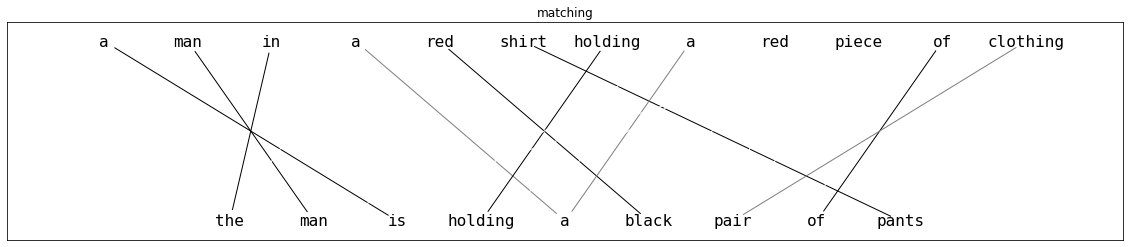

In [5]:

# use OT to compute a matching. For sake of example, we use the ot method from the POT package to get a matching. 
# But the explainer can work with other types of matchings, as long they are properly normalized (with the sinkhorn_knopp)

import ot
_, matching = ot.lp.emd2(
    a, b, C,
    return_matrix=True,
)
matching = matching['G']

# visualize the matching
import matplotlib.pyplot as plt
from utils.plot import plot_transport_plan_graph

fig = plt.figure(figsize=(20, 4))

# plot the matching
ax = plt.gca()
plot_transport_plan_graph(
    zip(words_a, a),
    zip(words_b, b),
    matching,
    ax=ax,
)

ax.set_title('matching')


### Explaining the Matching

Using the `OTMatchingExplainer`, we can get some explaination of how well `matching` is fitted to the cost matrix `C`. In particular, `OTMatchingExplainer` will generate some `NUM_ALTERNATVES` number of matchings, each alternative corresponding to a *sparse* number of salient matches that could also be relevant. 

This is akin to performing a web search, where the engine provides a number of relevant searches. The `OTMatchingExplainer` provides a number of relevant matches, and with each alternative, highlights the salient matches that differ from that of the base `matching`.

In [6]:
# parameters

# number of alternate matches
NUM_ALTERNATVES = 4

In [7]:
from aix360.algorithms.matching import OTMatchingExplainer

explainer = OTMatchingExplainer()
alternate = explainer.explain_instance(
    matching=matching, # matching
    costs=C,
    constraints=(a,b),
    num_alternate_matchings=NUM_ALTERNATVES,
    search_thresholds=(.5, .5), # trade off diversity of the solutions
    search_depth_limit=1, # trade off between a more thorough search vs compute time
    search_node_limit=20, # trade off between a more thorough search vs compute time
    search_match_pos_filter=non_stop_words, # ignore the stop words when producing alternate matchings
)
len(alternate)

4

In [8]:
explainer._model._history

[History(index=[(8, 1)], bound_value=3.9376030722522555, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f54849ad310>, skip=False),
 History(index=[(8, 3)], bound_value=3.924510218151589, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f548211e9d0>, skip=False),
 History(index=[(8, 5)], bound_value=3.0888149458000234, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f548498d450>, skip=False),
 History(index=[(8, 6)], bound_value=3.161874583184749, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f548212ac10>, skip=False),
 History(index=[(8, 8)], bound_value=3.4234777890518373, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f548212ad90>, skip=False),
 History(index=[(9, 1)], bound_value=3.8101834540989867, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f54820e60d0>, skip=False),
 History(index=[(9, 3)], bound_value=3.887623714464206, algo=<otoc.iterative.dual_method.DualMethod object at 0x7f54820e6f50>, skip=False),
 History(index=[

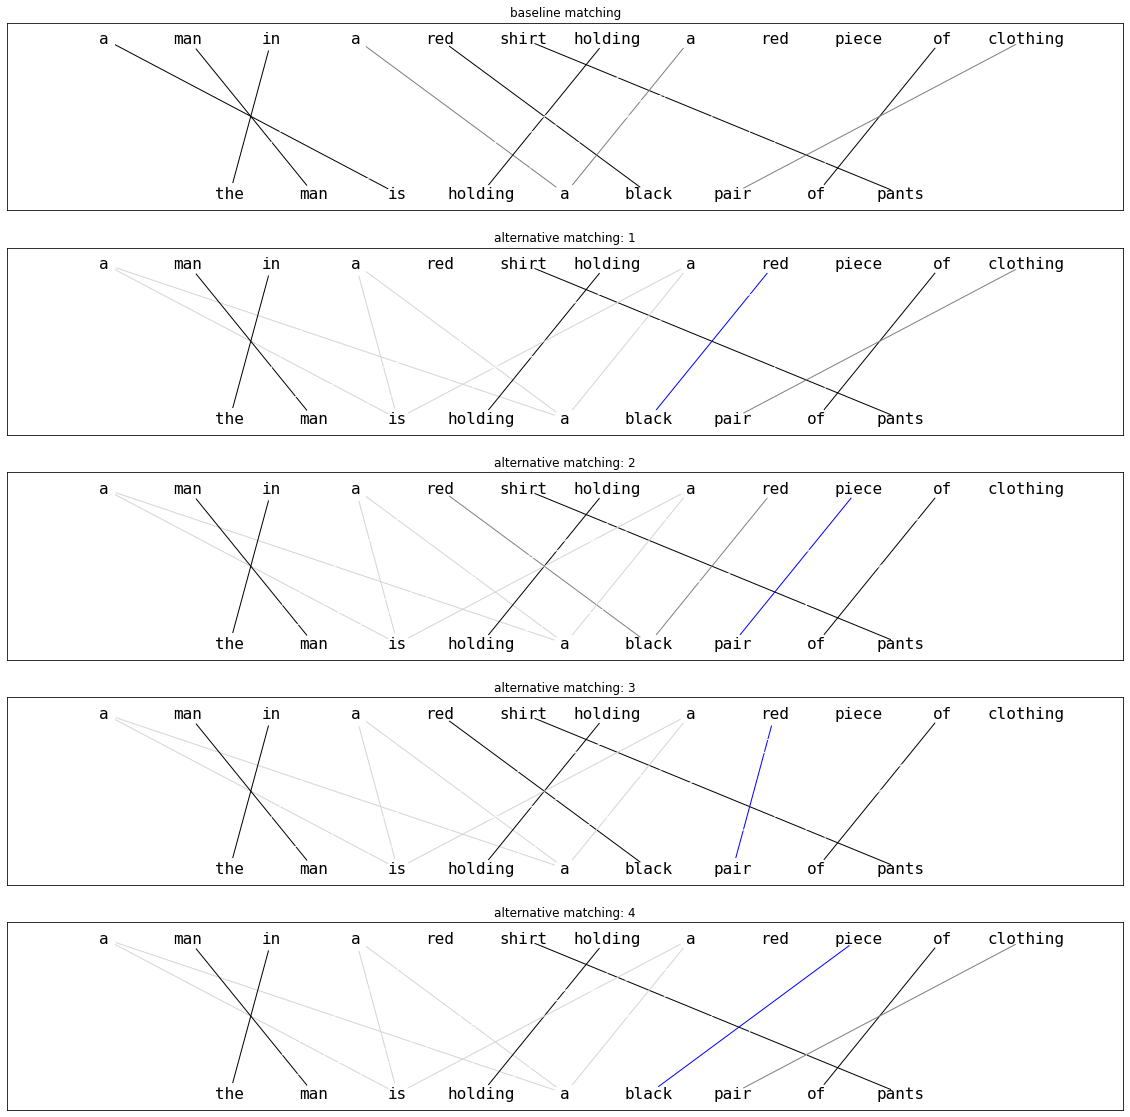

In [9]:
# plot the alternate solutions

# setting this to a larger number ignores the small coefficients in the matching plots below
# as such this causes the plot to appear as though the row/column constraints are not satisfied
# but this is not actually the case.
VMIN = 3

grid = plt.GridSpec(NUM_ALTERNATVES+1, 1)
fig = plt.figure(figsize=(20,4 * (NUM_ALTERNATVES+1)))

# plot the baseline matching for comparison
ax = fig.add_subplot(grid[0,0])
plot_transport_plan_graph(
    zip(words_a, a), zip(words_b, b),
    matching,
    ax=ax,
    vmin=VMIN / m / n,
)
ax.set_title('baseline matching')


# plot the alternate matches
for i in range(NUM_ALTERNATVES):
    ax = fig.add_subplot(grid[i+1,0])
    plot_transport_plan_graph(
        zip(words_a, a), zip(words_b, b),
        alternate[i].matching,
        highlight_edges=alternate[i].salient,
        ax=ax,
        vmin=VMIN / m / n,
    )
    ax.set_title(f'alternative matching: {i+1}')
    